In [53]:
## koppen climate clasification

import xarray as xr
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px


In [74]:
# Open and read the legend.txt file
with open("../data/koppen_geiger_nc/legend.txt", "r") as file:
    lines = file.readlines()

climate_short_name_dict = {}
climate_long_name_dict = {}

for line in lines:
    line = line.strip()
    if line and line[0].isdigit(): 
        parts = line.split(':')
        
        key = int(parts[0].strip())
        
        name = parts[1].split('[')[0].strip()
        
        short_name = name.split()[0]
        long_name = ' '.join(name.split()[1:])
        
        climate_short_name_dict[key] = short_name
        climate_long_name_dict[key] = long_name

climate_short_name_dict[0] = "nan"
climate_long_name_dict[0] = "Missing Data"

print("Short Name Dictionary:", climate_short_name_dict)
print("Long Name Dictionary:", climate_long_name_dict)

Short Name Dictionary: {1: 'Af', 2: 'Am', 3: 'Aw', 4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk', 8: 'Csa', 9: 'Csb', 10: 'Csc', 11: 'Cwa', 12: 'Cwb', 13: 'Cwc', 14: 'Cfa', 15: 'Cfb', 16: 'Cfc', 17: 'Dsa', 18: 'Dsb', 19: 'Dsc', 20: 'Dsd', 21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd', 25: 'Dfa', 26: 'Dfb', 27: 'Dfc', 28: 'Dfd', 29: 'ET', 30: 'EF', 0: 'nan'}
Long Name Dictionary: {1: 'Tropical, rainforest', 2: 'Tropical, monsoon', 3: 'Tropical, savannah', 4: 'Arid, desert, hot', 5: 'Arid, desert, cold', 6: 'Arid, steppe, hot', 7: 'Arid, steppe, cold', 8: 'Temperate, dry summer, hot summer', 9: 'Temperate, dry summer, warm summer', 10: 'Temperate, dry summer, cold summer', 11: 'Temperate, dry winter, hot summer', 12: 'Temperate, dry winter, warm summer', 13: 'Temperate, dry winter, cold summer', 14: 'Temperate, no dry season, hot summer', 15: 'Temperate, no dry season, warm summer', 16: 'Temperate, no dry season, cold summer', 17: 'Cold, dry summer, hot summer', 18: 'Cold, dry summer, warm summer'

In [55]:
# Load the NetCDF file
nc_file = "../data/koppen_geiger_nc/1991_2020/koppen_geiger_0p00833333.nc"
ds = xr.open_dataset(nc_file)

# Load the world shapefile
shapefile = "../data/world-administrative-boundaries/world-administrative-boundaries.shp"
world = gpd.read_file(shapefile)

In [56]:
# Extract variables
lon = ds['lon'].values
lat = ds['lat'].values
kg_class = ds['kg_class'].values

In [75]:
# List to store DataFrames for each country
dfs = []

countries = world['name'].unique()

for country_name in countries:
    country = world[world['name'] == country_name]
    
    transform = rasterio.transform.from_bounds(lon.min(), lat.min(), lon.max(), lat.max(), kg_class.shape[1], kg_class.shape[0])
    
    mask = rasterio.features.geometry_mask([country.geometry.values[0]], transform=transform, invert=True, out_shape=kg_class.shape)
    
    print(country_name)
    country_climate = np.ma.masked_array(kg_class, mask=~mask)
    
    unique, counts = np.unique(country_climate.compressed(), return_counts=True)
    total_pixels = counts.sum()

    percentages = counts / total_pixels * 100
    
    climate_info_df = pd.DataFrame({
        'Country': country_name,
        'Climate_Class': unique,
        'Short_Name': [climate_short_name_dict[cl] for cl in unique],
        'Long_Name': [climate_long_name_dict[cl] for cl in unique],
        'Count': counts,
        'Percentage': percentages
    })
    
    dfs.append(climate_info_df)

concatenated_df = pd.concat(dfs, ignore_index=True)


Northern Mariana Islands
Kuril Islands
France
Serbia
Uruguay
Guam
Panama
Netherlands Antilles
Algeria
Togo
Ma'tan al-Sarra
Switzerland
Jersey
Austria
Portugal
Luxembourg
Kazakhstan
Aruba
Holy See
Equatorial Guinea
Jamaica
Estonia
Niger
Belize
Morocco
Mexico
Romania
Belarus
Ecuador
Sudan
United Republic of Tanzania
Micronesia (Federated States of)
Antigua & Barbuda
Norway
Bangladesh
Denmark
Belgium
Samoa
Anguilla
Israel
Libyan Arab Jamahiriya
New Zealand
Madeira Islands
Kenya
Oman
Republic of Korea
Montserrat
Liberia
Rwanda
Nicaragua
Mozambique
Malta
Finland
Turkey
Lithuania
Russian Federation
Zimbabwe
Singapore
Uganda
Uzbekistan
Ireland
Eritrea
Argentina
Congo
Bahamas
Chile
Guinea
British Indian Ocean Territory
Saint Kitts and Nevis
Solomon Islands
Pitcairn Island
Saint Lucia
Turkmenistan
French Southern and Antarctic Territories
Slovenia
El Salvador
Cook Islands
Kuwait
Brunei Darussalam
Cape Verde
Italy
Iran (Islamic Republic of)
United Arab Emirates
British Virgin Islands
San Marino


In [76]:
concatenated_df

,Country,Climate_Class,Short_Name,Long_Name,Count,Percentage
0,Northern Mariana Islands,0.0,nan,Missing Data,68,23.529412
1,Northern Mariana Islands,1.0,Af,"Tropical, rainforest",221,76.470588
2,Kuril Islands,0.0,nan,Missing Data,857,10.656553
3,Kuril Islands,26.0,Dfb,"Cold, no dry season, warm summer",2350,29.221587
4,Kuril Islands,27.0,Dfc,"Cold, no dry season, cold summer",4816,59.885601
...,...,...,...,...,...,...
1575,Albania,19.0,Dsc,"Cold, dry summer, cold summer",30,0.067783
1576,Albania,26.0,Dfb,"Cold, no dry season, warm summer",7580,17.126460
1577,Albania,27.0,Dfc,"Cold, no dry season, cold summer",913,2.062857
1578,Gibraltar,0.0,nan,Missing Data,6,40.000000


In [77]:
climate_counts = concatenated_df.groupby('Country')['Climate_Class'].nunique().reset_index()

climate_counts.columns = ['Country', 'Number_of_Koppen_Climates']

climate_counts


,Country,Number_of_Koppen_Climates
0,Abyei,2
1,Afghanistan,17
2,Aksai Chin,4
3,Albania,9
4,Algeria,8
...,...,...
251,West Bank,4
252,Western Sahara,2
253,Yemen,8
254,Zambia,4


In [78]:
# Simple plot

climate_counts = climate_counts.rename(columns={'Country': 'name'})

world_with_climate_info = world.merge(climate_counts, on='name', how='left')

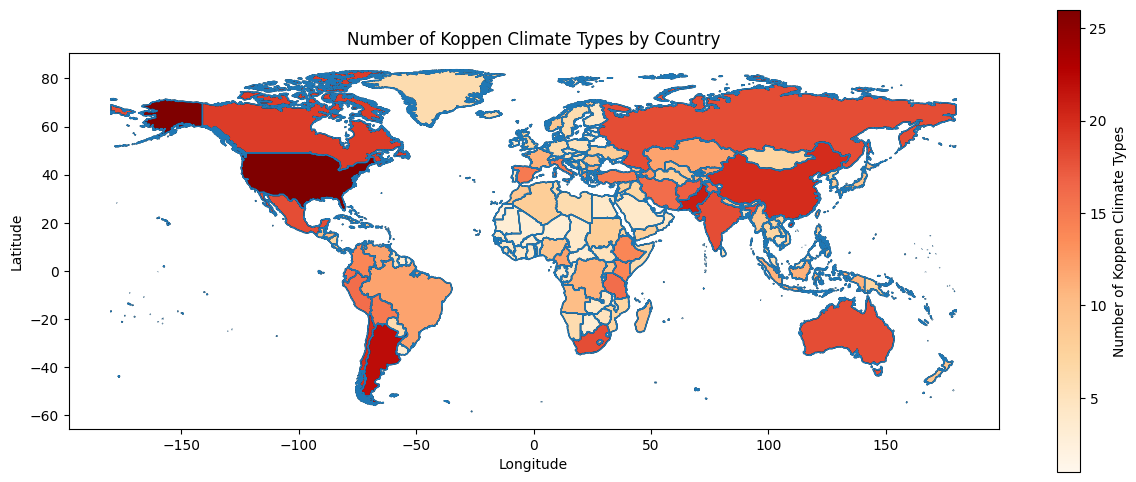

In [79]:

# Create the plot with a vertical color bar
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_with_climate_info.boundary.plot(ax=ax, linewidth=1)
cmap = 'OrRd'

# Plot the map with the color bar
pc = world_with_climate_info.plot(column='Number_of_Koppen_Climates', ax=ax, cmap=cmap,
                                  edgecolor='black', legend=True,
                                  legend_kwds={'label': "Number of Koppen Climate Types",
                                               'orientation': "vertical", 
                                               'shrink': 0.6, 'aspect': 20})

# Adjust the legend and layout
ax.set_title('Number of Koppen Climate Types by Country')
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');